In [1]:
# STEP 1: Import libraries and set up device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# STEP 2: Load and preprocess NSL-KDD dataset

# Column names
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load data
train_df = pd.read_csv("data/KDDTrain+.txt", names=columns)
test_df = pd.read_csv("data/KDDTest+.txt", names=columns)

# Drop 'difficulty_degree'
train_df.drop("difficulty_degree", axis=1, inplace=True)
test_df.drop("difficulty_degree", axis=1, inplace=True)

# Encode categoricals
for col in ["protocol_type", "service", "flag"]:
    train_df[col] = train_df[col].astype("category").cat.codes
    test_df[col] = test_df[col].astype("category").cat.codes

# Binary labels
train_df["labels"] = train_df["labels"].apply(lambda x: 1 if x == "normal" else 0)
test_df["labels"] = test_df["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train_full = train_df.drop("labels", axis=1)
y_train_full = train_df["labels"]
X_test = test_df.drop("labels", axis=1)
y_test = test_df["labels"]

# Normalize
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

# Convert to torch tensors
def to_tensor_dataset(X, y):
    return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))

train_dataset = to_tensor_dataset(X_train, y_train)
val_dataset = to_tensor_dataset(X_val, y_val)
test_dataset = to_tensor_dataset(X_test, y_test)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [3]:
# STEP 3: Define Autoencoder (Encoder only) + Classifier

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

class AEClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=32):
        super(AEClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)


In [4]:
# STEP 4: Define Transformer-only model

class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.expand_dim = nn.Linear(input_dim, 32)
        self.attn_layer = nn.TransformerEncoderLayer(d_model=32, nhead=4, dim_feedforward=64, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.attn_layer, num_layers=2)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.expand_dim(x).unsqueeze(1)  # Add sequence dimension
        x = self.encoder(x)
        x = x.squeeze(1)  # Remove sequence dim
        return self.classifier(x)


In [5]:
# STEP 5: Hybrid model = Encoder + Transformer

class HybridModel(nn.Module):
    def __init__(self, encoder, latent_dim=32):
        super(HybridModel, self).__init__()
        self.encoder = encoder
        self.expand_dim = nn.Linear(latent_dim, 32)
        self.attn_layer = nn.TransformerEncoderLayer(d_model=32, nhead=4, dim_feedforward=64, dropout=0.3, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.attn_layer, num_layers=2)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.expand_dim(z).unsqueeze(1)
        z = self.transformer(z).squeeze(1)
        return self.classifier(z)


In [6]:
# STEP 6: Train and evaluate functions for all models
import time
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, is_autoencoder=False):
    model.to(device)
    criterion = nn.MSELoss() if is_autoencoder else nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, xb) if is_autoencoder else criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        end_time = time.time()

    training_duration = end_time - start_time
    print(f"Total Training Time: {training_duration:.2f} seconds")
    return model, training_duration


# def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, is_autoencoder=False):
    

#     model.to(device)
#     criterion = nn.MSELoss() if is_autoencoder else nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)

#     print(f"Training {model.__class__.__name__}...")

#     start_time = time.time()
#     for epoch in range(epochs):
#         model.train()
#         total_loss = 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
#             optimizer.zero_grad()
#             preds = model(xb)
#             loss = criterion(preds, xb) if is_autoencoder else criterion(preds, yb)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
#     end_time = time.time()

#     training_duration = end_time - start_time
#     print(f"Total Training Time: {training_duration:.2f} seconds")
#     return model, training_duration



def get_predictions(model, loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            probs = model(xb).squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


def evaluate_model(model, loader, label):
    y_true, y_pred, y_prob = get_predictions(model, loader)

    print(f"\n=== {label} ===")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
    plt.title(f"{label} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{label} - Confusion Matrix.png")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{label} -ROC Curve")
    plt.savefig(f"{label} -ROC Curve.png")
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(rec, prec, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{label} -Precision-Recall Curve")
    plt.savefig(f"{label} -Precision-Recall Curve.png")
    plt.grid()
    plt.legend()
    plt.show()


In [7]:
# STEP 7: Train and evaluate all models

input_dim = X_train.shape[1]
latent_dim = 32

# ---- (1) Train Autoencoder ----
autoencoder = Autoencoder(input_dim, latent_dim)
print("\nTraining Autoencoder...")
autoencoder, t_time_auto =  train_model(autoencoder, train_loader, val_loader, epochs=20, lr=1e-3, is_autoencoder=True)

# Freeze encoder for classification
encoder_only = autoencoder.encoder
ae_clf = AEClassifier(encoder_only, latent_dim)
print("\nTraining Autoencoder-Only Classifier...")
ae_clf, t_time_encoder_only = train_model(ae_clf, train_loader, val_loader, epochs=20, lr=1e-3)

# ---- (2) Train Transformer-only ----
transformer_only = TransformerModel(input_dim)
print("\nTraining Transformer-Only Model...")
transformer_only, t_time_transformer_only = train_model(transformer_only, train_loader, val_loader, epochs=20, lr=1e-3)

# ---- (3) Train Hybrid (Autoencoder + Transformer) ----
# Use the same encoder again
hybrid_model = HybridModel(encoder_only, latent_dim)
print("\nTraining Hybrid Autoencoder + Transformer Model...")
hybrid_model, t_time_hybrid = train_model(hybrid_model, train_loader, val_loader, epochs=20, lr=1e-3)



Training Autoencoder...
Epoch 1/20, Loss: 0.9252
Epoch 2/20, Loss: 0.9069
Epoch 3/20, Loss: 0.9056
Epoch 4/20, Loss: 0.8894
Epoch 5/20, Loss: 0.8589
Epoch 6/20, Loss: 0.8375
Epoch 7/20, Loss: 0.8230
Epoch 8/20, Loss: 0.8009
Epoch 9/20, Loss: 0.7839
Epoch 10/20, Loss: 0.7778
Epoch 11/20, Loss: 0.7604
Epoch 12/20, Loss: 0.7370
Epoch 13/20, Loss: 0.7255
Epoch 14/20, Loss: 0.7252
Epoch 15/20, Loss: 0.7249
Epoch 16/20, Loss: 0.7246
Epoch 17/20, Loss: 0.7244
Epoch 18/20, Loss: 0.7243
Epoch 19/20, Loss: 0.7242
Epoch 20/20, Loss: 0.7219
Total Training Time: 51.03 seconds

Training Autoencoder-Only Classifier...
Epoch 1/20, Loss: 0.0575
Epoch 2/20, Loss: 0.0321
Epoch 3/20, Loss: 0.0298
Epoch 4/20, Loss: 0.0242
Epoch 5/20, Loss: 0.0262
Epoch 6/20, Loss: 0.0225
Epoch 7/20, Loss: 0.0211
Epoch 8/20, Loss: 0.0197
Epoch 9/20, Loss: 0.0197
Epoch 10/20, Loss: 0.0189
Epoch 11/20, Loss: 0.0183
Epoch 12/20, Loss: 0.0179
Epoch 13/20, Loss: 0.0175
Epoch 14/20, Loss: 0.0172
Epoch 15/20, Loss: 0.0175
Epoch 1


=== Autoencoder-Only Classifier ===
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77     12833
         1.0       0.67      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.85      0.79      0.78     22544



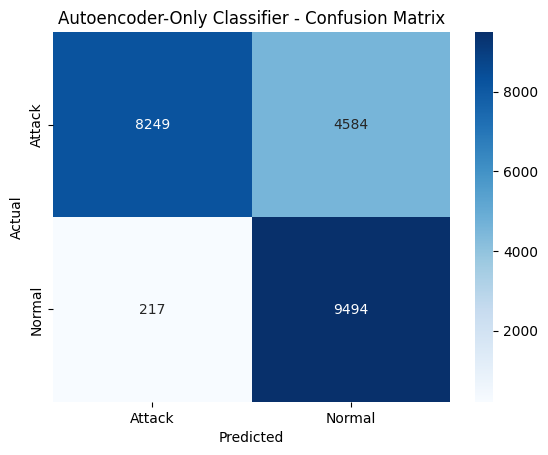

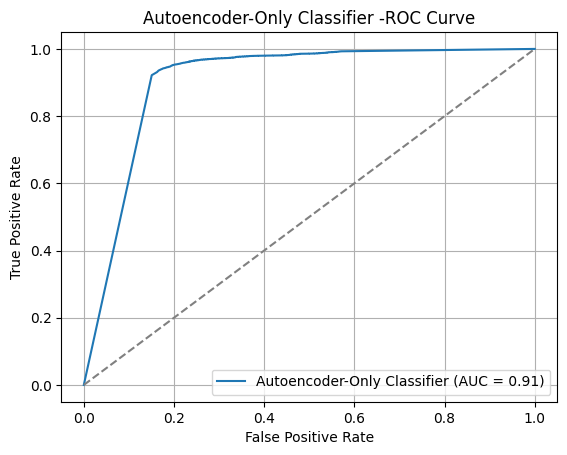

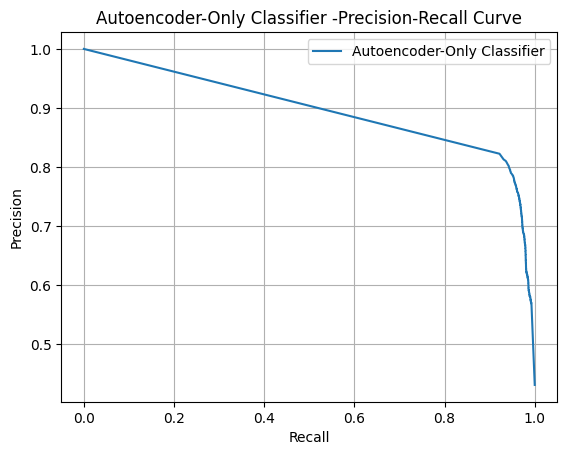


=== Transformer-Only Model ===
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.78     12833
         1.0       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544



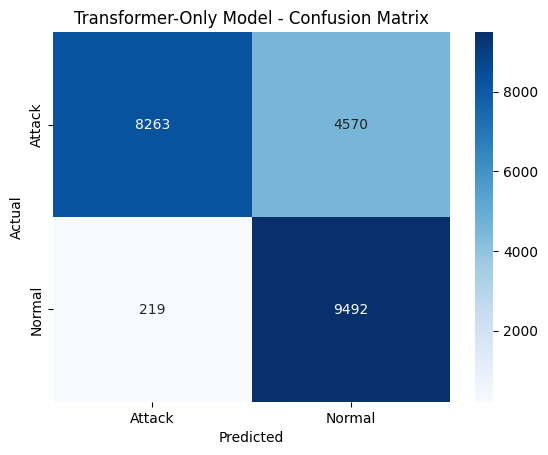

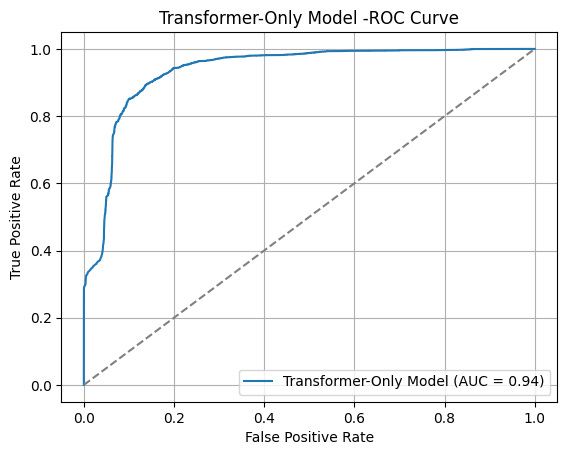

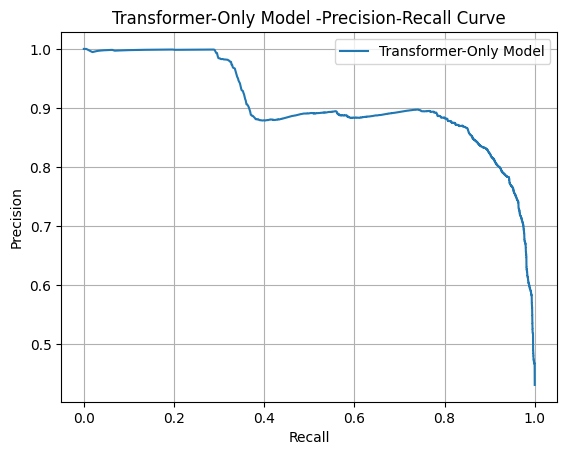


=== Hybrid Autoencoder + Transformer ===
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     12833
         1.0       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544



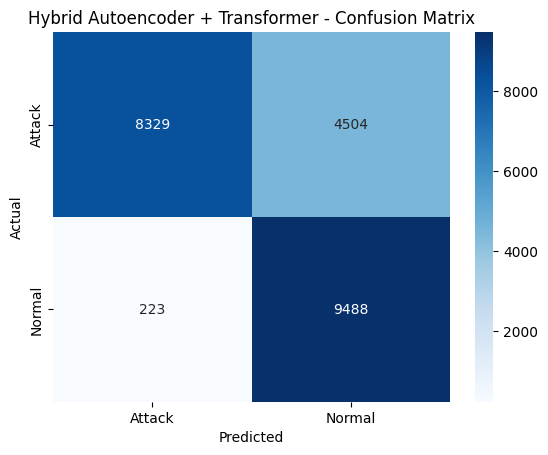

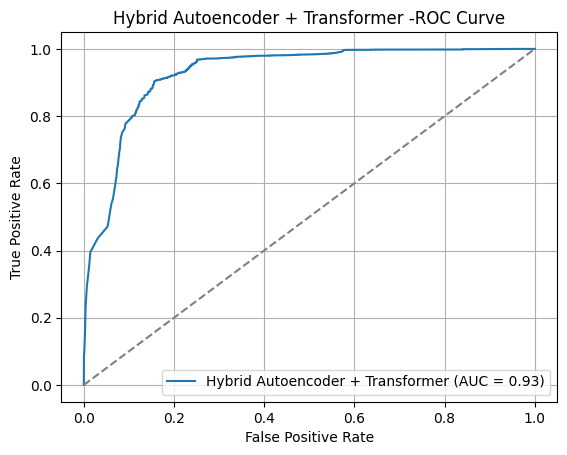

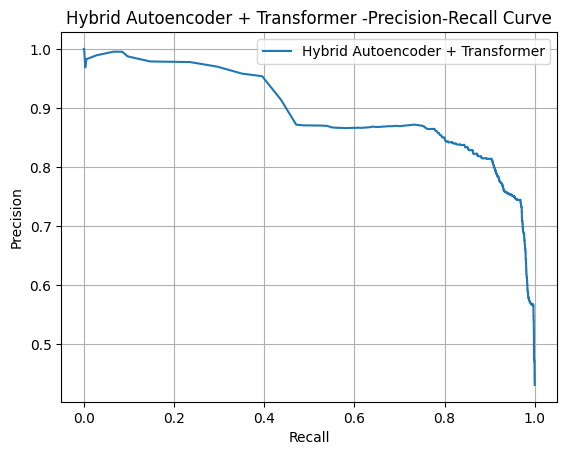

In [8]:
# ---- Evaluate All Models on Test Set ----
evaluate_model(ae_clf, test_loader, "Autoencoder-Only Classifier")
evaluate_model(transformer_only, test_loader, "Transformer-Only Model")
evaluate_model(hybrid_model, test_loader, "Hybrid Autoencoder + Transformer")

In [9]:
def compute_efficiency_metrics(model, dataloader, name, train_time):
    import torch
    import tempfile
    import os
    import time

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Save to temp file to get size
    with tempfile.NamedTemporaryFile(delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mb = os.path.getsize(tmp.name) / 1e6
        os.remove(tmp.name)

    # Inference time per sample
    model.eval()
    start = time.time()
    with torch.no_grad():
        for xb, _ in dataloader:
            xb = xb.to(device)
            _ = model(xb)
    end = time.time()
    total_time = end - start
    avg_infer_ms = (total_time / len(dataloader.dataset)) * 1000

    # GPU name
    gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

    print(f"\n--- {name} Computational Metrics ---")
    print(f"Parameters        : {total_params:,}")
    print(f"Model Size        : {size_mb:.2f} MB")
    print(f"Inference Time    : {avg_infer_ms:.4f} ms/sample")
    print(f"Training Time     : {train_time:.2f} seconds")
    print(f"GPU Used          : {gpu_name}")

    return {
        "Model": name,
        "Params": total_params,
        "Size_MB": round(size_mb, 2),
        "Infer_ms": round(avg_infer_ms, 4),
        "Train_s": round(train_time, 2),
        "GPU": gpu_name
    }


In [10]:
# STEP 9: Compute and compare efficiency metrics

efficiency_results = []

efficiency_results.append(compute_efficiency_metrics(ae_clf, test_loader, "Autoencoder-Only", t_time_auto))
efficiency_results.append(compute_efficiency_metrics(transformer_only, test_loader, "Transformer-Only", t_time_transformer_only))
efficiency_results.append(compute_efficiency_metrics(hybrid_model, test_loader, "Hybrid AE+Transformer", t_time_hybrid))

import pandas as pd
eff_df = pd.DataFrame(efficiency_results)
print("\n=== Efficiency Summary Table ===")
print(eff_df)



--- Autoencoder-Only Computational Metrics ---
Parameters        : 17,889
Model Size        : 0.08 MB
Inference Time    : 0.0093 ms/sample
Training Time     : 51.03 seconds
GPU Used          : NVIDIA GeForce RTX 3080

--- Transformer-Only Computational Metrics ---
Parameters        : 29,153
Model Size        : 0.13 MB
Inference Time    : 0.0149 ms/sample
Training Time     : 119.82 seconds
GPU Used          : NVIDIA GeForce RTX 3080

--- Hybrid AE+Transformer Computational Metrics ---
Parameters        : 44,577
Model Size        : 0.20 MB
Inference Time    : 0.0166 ms/sample
Training Time     : 129.37 seconds
GPU Used          : NVIDIA GeForce RTX 3080

=== Efficiency Summary Table ===
                   Model  Params  Size_MB  Infer_ms  Train_s  \
0       Autoencoder-Only   17889     0.08    0.0093    51.03   
1       Transformer-Only   29153     0.13    0.0149   119.82   
2  Hybrid AE+Transformer   44577     0.20    0.0166   129.37   

                       GPU  
0  NVIDIA GeForce R